In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_scores, plot_predict_result
%matplotlib notebook

In [4]:
df = pd.read_csv('../data/ready/dataset_houses.csv')
df = df[df['precio']<1000000]

features = df.drop(columns='precio')
price = df['precio']

# Usefull methods to explore features
- df.description()
- df.shape
- df.count()
- df.sum()
- df.mean()
- df.std()
- df.corr()

- `df['feature'].unique()`
- `df.nunique()`
- `df['feature'].isna()`



# Modeling

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
# Train/test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Descomposition
from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
# Cross-validation
from sklearn.model_selection import cross_val_score

from scipy.stats import norm, skew


## Split train and test dataset

In [6]:
X_train, X_test = train_test_split(features, test_size=0.2, random_state=0)
y_train, y_test = train_test_split(price, test_size=0.2, random_state=0)

## Check train and test distributions

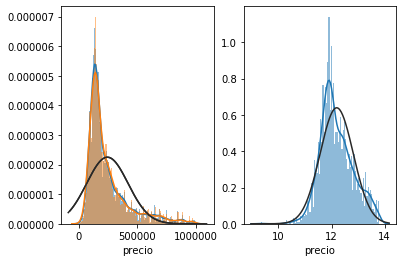

In [7]:
f, ax = plt.subplots(1,2)
sns.distplot(y_train, bins=100, hist_kws={'alpha':0.5}, fit=norm, ax=ax[0]);
sns.distplot(y_test, bins=100, hist_kws={'alpha':0.5}, fit=norm, ax=ax[0]);
sns.distplot(np.log1p(y_test), bins=100, hist_kws={'alpha':0.5}, fit=norm, ax=ax[1]);

## Scale dataset

In [8]:
# scaler =  RobustScaler(quantile_range=(25, 75))
scaler_target = QuantileTransformer(output_distribution='normal', ) 
# scaler = PowerTransformer(method='box-cox')  # Non Linear | Strictly positive data
# scaler = PowerTransformer(method='yeo-johnson')  # Non Linear 
scaler_feature = MinMaxScaler()


In [9]:
X_train_norm = scaler_feature.fit_transform(X_train)
# scale_train = scaler_feature.transform(X_train)
X_test_norm = scaler_feature.transform(X_test)

y_train_norm = scaler_target.fit_transform(y_train.to_numpy()[:, None])
y_test_norm = scaler_target.transform(y_test.to_numpy()[:, None])

## PCA analysis

In [10]:
pca = PCA(n_components=.98, )
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

In [11]:
pca.explained_variance_ratio_

array([0.16931876, 0.11887327, 0.08923624, 0.0823609 , 0.06028471,
       0.0511455 , 0.04575569, 0.03981486, 0.03205461, 0.02772286,
       0.02554175, 0.02389725, 0.02314492, 0.02093171, 0.01742225,
       0.01586492, 0.01573012, 0.01445018, 0.01335048, 0.01207   ,
       0.01143276, 0.01113541, 0.01036122, 0.01007787, 0.00912704,
       0.00845178, 0.00807326, 0.00719249, 0.00547484])

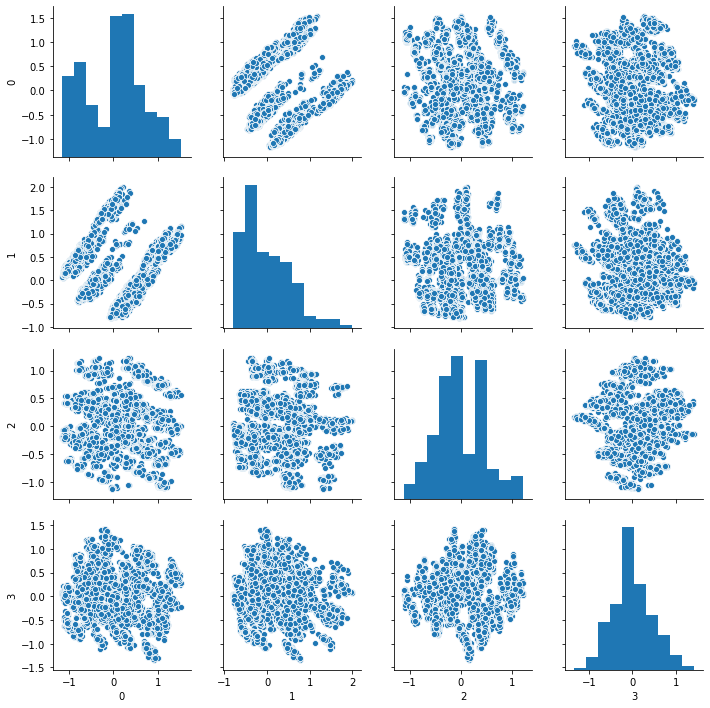

In [12]:
sns.pairplot(pd.DataFrame(X_train_pca[:, 0:4]))

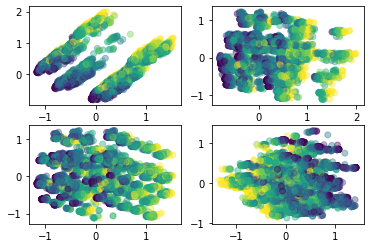

In [13]:
# color = features.loc[features.index, 'zona'].astype('category').cat.codes
color = X_train.iloc[:, 2]
f, ax = plt.subplots(2,2)
ax[0, 0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=color, alpha=0.4)
ax[0, 1].scatter(X_train_pca[:,1], X_train_pca[:,2], c=color, alpha=0.4)
ax[1, 0].scatter(X_train_pca[:,0], X_train_pca[:,2], c=color, alpha=0.4)
ax[1, 1].scatter(X_train_pca[:,3], X_train_pca[:,5], c=color, alpha=0.4)

# Choosing a model

## Linear Model

MSE=10174509825.97, MAE=64879.65, MEAE=39025.12, $R^2$=0.68


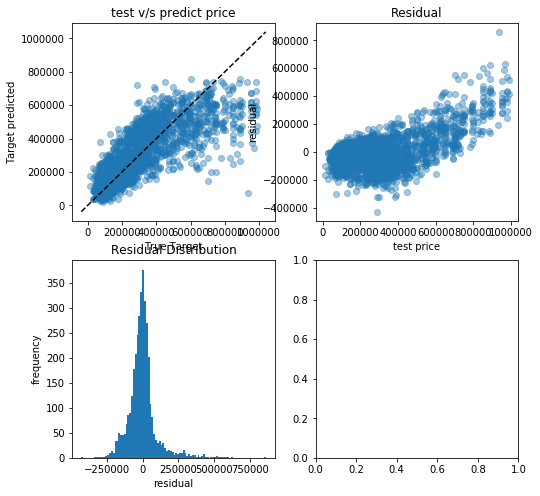

In [14]:
model = LinearRegression(fit_intercept=True)
model.fit(X_train_pca, y_train)
#model.coef_, model.intercept_, model.rank_

predicted_price_lr = model.predict(X_test_pca)
print(get_scores(y_test, predicted_price_lr))


f, ax = plot_predict_result(y_test, predicted_price_lr)


## Transformed Target Regressor

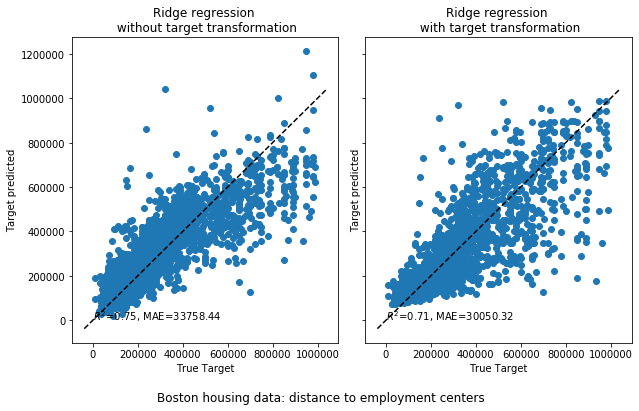

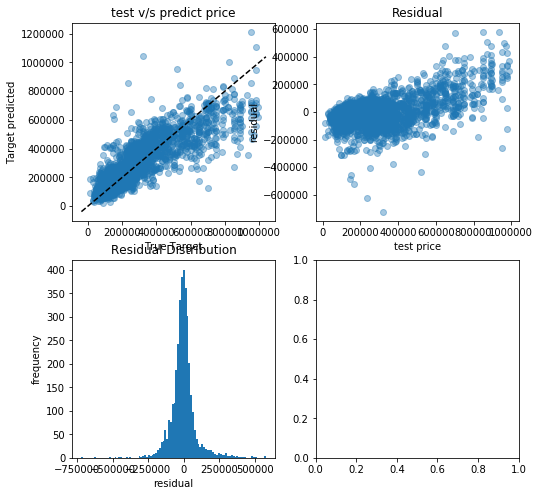

(<Figure size 576x576 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f580ef1a630>,
       dtype=object))

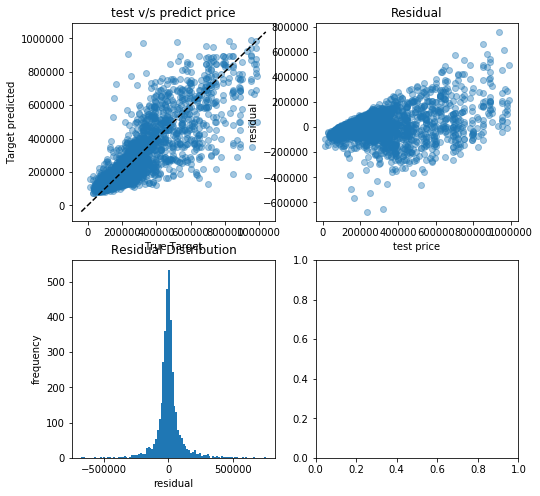

In [16]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
predicted_price_rid = regr.predict(X_test)

ax0.scatter(y_test, predicted_price_rid)
ax0.plot(ax0.get_xbound(), ax0.get_xbound(), '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$={:.2f}, MAE={:.2f}'.format(r2_score(y_test, predicted_price_rid),
                                                  median_absolute_error(y_test, predicted_price_rid)))

plot_predict_result(y_test, predicted_price_rid)

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
predicted_price_rid_tr = regr_trans.predict(X_test)

ax1.scatter(y_test, predicted_price_rid_tr)
ax1.plot(ax1.get_xbound(), ax1.get_xbound(), '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 9, r'$R^2$={:.2f}, MAE={:.2f}'.format(r2_score(y_test, predicted_price_rid_tr),
                                                  median_absolute_error(y_test, predicted_price_rid_tr)))
# ax1.set_xlim([0, 10])
# ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()
plot_predict_result(y_test, predicted_price_rid_tr)


In [17]:
cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                        eps=1e-3,
                        n_alphas=100,
                        fit_intercept=True, 
                        normalize=True,
                        precompute='auto',
                        max_iter=2000,
                        tol=0.0001,
                        cv=6, 
                        copy_X=True,
                        verbose=0,
                        n_jobs=-1,
                        positive=False,
                        random_state=0)

In [18]:
cv_model.fit(X_train, y_train)


ElasticNetCV(alphas=None, copy_X=True, cv=6, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_alphas=100, n_jobs=-1, normalize=True, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [19]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 1.41510395
Optimal l1_ratio: 1.000
Number of iterations 61


In [20]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.6950289755716652
Test r2 score:  0.7469392682964603
Train RMSE: 85583.9910
Test RMSE: 89155.5774


36 features, reduction of 7.69%


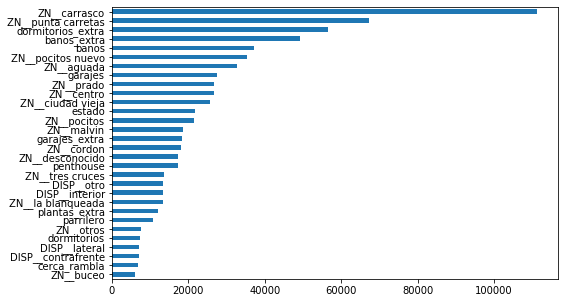

In [21]:

feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

f, ax = plt.subplots(figsize = (8, 5))
feature_importance.sort_values().tail(30).plot(kind='barh', ax=ax);

# Regression Tree

In [22]:
cls_tree = DecisionTreeRegressor()
cls_tree.fit(X_train, y_train)


predicted_price_tree = cls_tree.predict(X_test)
print(get_scores(predicted_price_tree, y_test))

scores_accuracy = cross_val_score(cls_tree, features, price, cv=10)
# scores_balanced = cross_val_score(cls_tree, features, price, cv=10, scoring="balanced_accuracy")

scores_accuracy, scores_accuracy.mean()



MSE=10245229682.32, MAE=55771.71, MEAE=26000.00, $R^2$=0.67


(array([0.64458875, 0.67828635, 0.70182508, 0.71405033, 0.72101326,
        0.68905528, 0.68427991, 0.6835688 , 0.70646879, 0.66475264]),
 0.6887889185469833)

(<Figure size 576x576 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f580f00e4a8>,
       dtype=object))

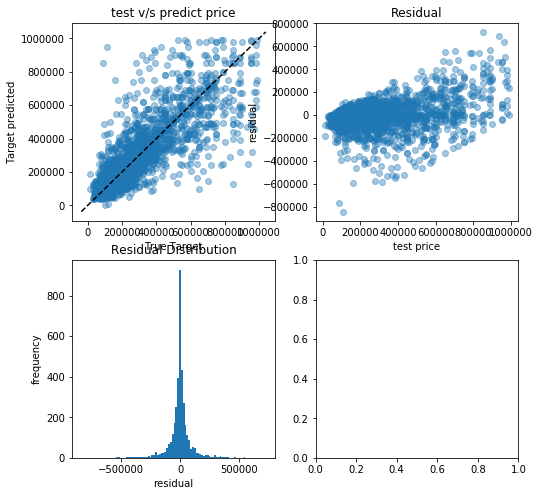

In [24]:
plot_predict_result(y_test, predicted_price_tree)

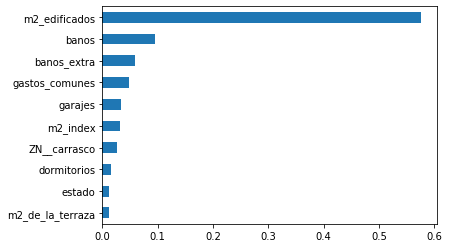

In [25]:
f, ax = plt.subplots()
(pd
 .Series(cls_tree.feature_importances_, index=X_test.columns)
 .sort_values()[-10:]
 .plot(ax=ax, kind='barh')
)

## Random Forest

In [30]:
rfr = RandomForestRegressor(n_estimators=100,)
rfr.fit(X_train, y_train)
predicted_price_rf = rfr.predict(X_test)
print(get_scores(y_test, predicted_price_rf))



MSE=5398637704.66, MAE=43104.07, MEAE=22103.15, $R^2$=0.83


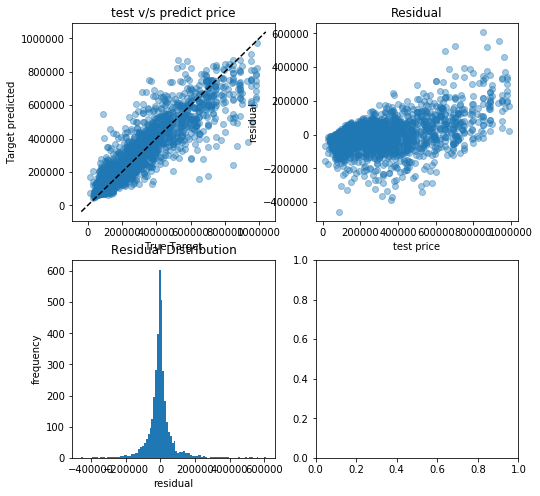

In [31]:
plot_predict_result(y_test, predicted_price_rf);


In [32]:
pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

m2_edificados         0.572228
banos                 0.118994
gastos_comunes        0.053247
m2_index              0.035216
banos_extra           0.034473
garajes               0.033391
ZN__carrasco          0.027359
dormitorios           0.014397
estado                0.013911
m2_de_la_terraza      0.011230
ZN__punta carretas    0.010643
ZN__pocitos           0.010362
ZN__otros             0.009409
parrilero             0.007215
plantas               0.006116
ZN__centro            0.005361
cerca_rambla          0.004237
DISP__otro            0.003628
DISP__al frente       0.003272
ZN__malvin            0.003170
ZN__cordon            0.002547
ZN__prado             0.002403
ZN__pocitos nuevo     0.002138
dormitorios_extra     0.001980
garajes_extra         0.001879
plantas_extra         0.001439
ZN__la blanqueada     0.001370
ZN__buceo             0.001290
ZN__parque batlle     0.001105
penthouse             0.000940
ZN__aguada            0.000909
vivienda_social       0.000857
DISP__co

## XGboost

In [33]:
from xgboost import XGBRegressor, plot_importance 


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

## Hiperparameters tunning

In [ ]:
rfr = RandomForestRegressor(n_estimators=100,)

# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


rfr.fit(X_train, y_train)
predicted_price_rf = rfr.predict(X_test)
print(get_scores(y_test, predicted_price_rf))

In [40]:
from time import time
from scipy.stats import randint as sp_randint

In [45]:
# build a classifier
clf = RandomForestRegressor(n_estimators=20, n_jobs=-1)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)



In [47]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 10],
#               "bootstrap": [True, False],
              "criterion": ["mse", "mae"]
             }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 185.68 seconds for 4 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.830 (std: 0.008)
Parameters: {'criterion': 'mae', 'max_depth': None}

Model with rank: 2
Mean validation score: 0.827 (std: 0.008)
Parameters: {'criterion': 'mse', 'max_depth': None}

Model with rank: 3
Mean validation score: 0.696 (std: 0.015)
Parameters: {'criterion': 'mse', 'max_depth': 3}

